In [15]:
import matplotlib.patches as mpatches
import numpy as np
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [16]:
params = {
   'axes.labelsize': 12,
   'font.size': 10,
   'legend.fontsize': 11,
   'xtick.labelsize': 10,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [10, 2] # instead of 4.5, 4.5
   }
plt.rcParams.update(params)

## helper function

In [17]:
def autolabel(rects, ses):
    # attach some text labels
    for rect, se in zip(rects, ses):
        height = rect.get_height()
        plt.axes().text(rect.get_x()+rect.get_width()/2., height+1.03*se, '{:2.3f}'.format(float(height)).lstrip('0'),
                ha='center', va='bottom',fontsize=10)

## Fixed Parameters

In [18]:
# experiment
exp = 'mapping_loo'
exp_label = 'Leave-one-out fMRI to Text Mapping'
base_md = 'avg' #baseline model
main_md = 'multi_srm' #main model

# dictionaries
cl_dict = {'class':{0:1/7,1:1/4,2:1/4,3:1/25},'rank':{0:1/2,1:1/2,2:1/2,3:1/2}} # chance level of each dataset
feat_dict = {'multi_srm':[200,50,150],'all_srm':[50,125,50],'all_ica':[25,25,25],\
             'all_gica':[75,50,75],'all_dict':[200,150,75],'avg':[50,50,50]}
roi_dict = {'dmn':0,'pt':1,'eac':2}
md_dict = {'avg':'MNI','multi_srm':'MDSRM','ica':'ICA','gica':'Group-ICA','dict':'Dict','srm':'SRM'}
ds_dict = {0:'GreenEyes',1:'Milky',2:'Vodka',3:'Sherlock'}
actp_dict = {'class':'Classification Accuracy','rank':'Ranking Accuracy'}
md_pre = ['all_']

# path
input_file = '../../output/accu_bar/{}/{}/{}_ds{}.npz' #exp,roi,model,ds
output_path = '../../output/figures/{}/' #exp
output_file = output_path+'{}_{}_ds{}' #roi,accu_type,ds
if not os.path.exists(output_path.format(exp)):
    os.makedirs(output_path.format(exp))

## Plotting Parameter

In [19]:
max_accu_all = [0.1,0.7] #accuracy for classification and ranking plots
datasets = [3]
# max_accu_all = [1.2,1.5] #accuracy for classification and ranking plots
# datasets = [1,2]
model_all = ['ica','gica','dict','srm']
roi_all = ['dmn','pt','eac']
accu_type = ['class','rank']

## Aggregate Accuracy

In [20]:
all_mean = [] # length # of roi
all_se = [] # length # of roi
# aggregate each roi,each type
for roi in roi_all:
    roi_mean = []
    roi_se = []
    for ac_tp in accu_type:
        roi_mean.append([])
        roi_se.append([])
    for ds in datasets:
        # baseline model
        ws=np.load(input_file.format(exp,roi,base_md,ds))
        for r,ac_tp in enumerate(accu_type):
            roi_mean[r].append(ws[ac_tp+'_mean'].item())
            roi_se[r].append(ws[ac_tp+'_se'].item())
        # add comparison models
        for model in model_all: 
            for pre in md_pre:
                ws=np.load(input_file.format(exp,roi,pre+model,ds))
                for r,ac_tp in enumerate(accu_type):
                    roi_mean[r].append(ws[ac_tp+'_mean'].item())
                    roi_se[r].append(ws[ac_tp+'_se'].item())
        # main model
        ws=np.load(input_file.format(exp,roi,main_md,ds))
        for r,ac_tp in enumerate(accu_type):
            roi_mean[r].append(ws[ac_tp+'_mean'].item())
            roi_se[r].append(ws[ac_tp+'_se'].item())
    all_mean.append(roi_mean)
    all_se.append(roi_se)

## Plot all roi

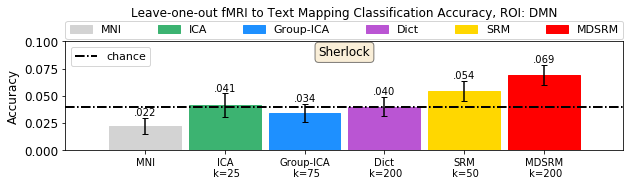

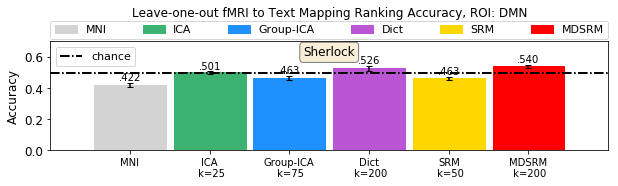

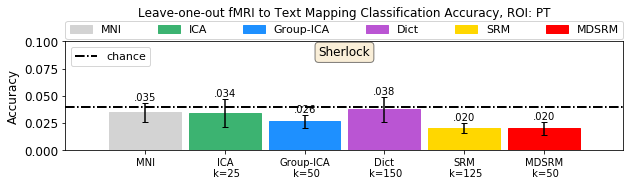

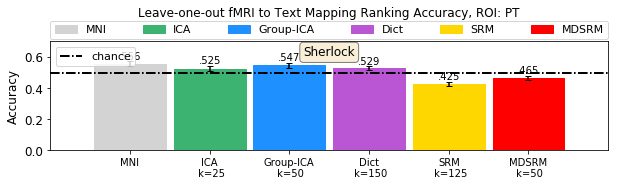

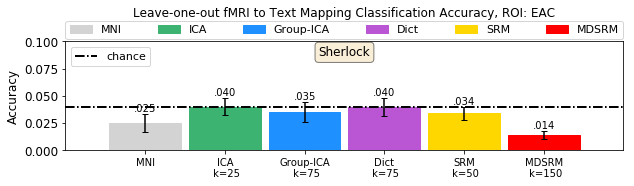

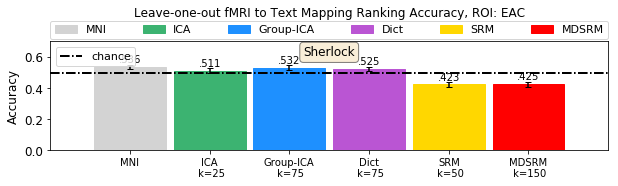

In [21]:
width=1
nmodel = len(model_all)*len(md_pre)+2 # number of models, including baseline model and main model
ndata = len(datasets)
group_width = 1.25*width*nmodel
center_all = np.linspace(0,group_width*(ndata-1),ndata)
# set colors
base_color = 'lightgrey'
main_color = 'red'
color_all = ['mediumseagreen','dodgerblue','mediumorchid','gold'] # at most 4 methods to compare

for m,roi in enumerate(roi_all):
    for r,ac_tp,max_accu in zip(range(len(accu_type)),accu_type,max_accu_all):
        # xtick 
        xtick_idx = []
        xtick_name = []    
        # dataset names
        ds_idx = []
        ds_name = []
        plt.figure()
        # configure bars
        for i,(ds, center) in enumerate(zip(datasets,center_all)):
            mean = list(all_mean[m][r][i*nmodel:(i+1)*nmodel])
            se   = list(all_se[m][r][i*nmodel:(i+1)*nmodel])    
            idx = np.arange(center,center+nmodel*width,width)
            error_config = {'ecolor': '0','capsize':3}   
            rects = plt.bar(idx, mean, yerr=se, align='center', error_kw=error_config, width = width-0.1)
            # set colors
            rects[0].set_color(base_color)
            for rect_i in range(1,len(rects)-1):
                rects[rect_i].set_color(color_all[rect_i-1])
            rects[-1].set_color(main_color)
            autolabel(rects,se)
            ds_idx.append(center+(nmodel-1)*width/2)        
            ds_name.append(ds_dict[ds])
            # xtick names
            xtick_idx.extend(idx)
            xtick_name.append(md_dict[base_md])
            for model in model_all:
                feat = str(feat_dict[md_pre[0]+model][roi_dict[roi]])
                xtick_name.append(md_dict[model]+'\n k='+feat)
            feat = str(feat_dict[main_md][roi_dict[roi]])
            xtick_name.append(md_dict[main_md]+'\n k='+feat)
            
        plt.xticks(xtick_idx,xtick_name)
        plt.ylabel('Accuracy')
        left_lim = center_all[0]-0.5*width-0.5
        right_lim = center_all[-1]+(nmodel-0.5)*width+0.5
        plt.xlim([left_lim,right_lim])
        plt.ylim([0,max_accu])

        # plot chance accuracy of each dataset
        for d,center in enumerate(center_all):
            cl = cl_dict[ac_tp][datasets[d]]
            line = plt.plot([center-width, center+(nmodel+1)*width], [cl, cl], 'k-.', linewidth=2)

        # Add texts
        plt.text((right_lim+left_lim)/2, 1.2*max_accu, exp_label+' '+actp_dict[ac_tp]+', ROI: '+roi.upper(),fontsize=12,horizontalalignment='center', verticalalignment='bottom')
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        for d in range(len(datasets)):
            plt.text(ds_idx[d],0.96*max_accu,ds_name[d],bbox=props,fontsize=12,horizontalalignment='center', verticalalignment='top')

        # legend
        legend_handle = []
        legend_handle.append(mpatches.Patch(color=base_color, label=md_dict[base_md]))
        for patch_i in range(len(model_all)):
            legend_handle.append(mpatches.Patch(color=color_all[patch_i], label=md_dict[model_all[patch_i]]))
        legend_handle.append(mpatches.Patch(color=main_color, label=md_dict[main_md]))        
        l1 = plt.legend(handles=legend_handle,bbox_to_anchor=(0.,1.02,1.,.102),loc=3,ncol=len(model_all)+2,mode="expand", borderaxespad=0.)
        ax = plt.gca().add_artist(l1)
        plt.legend(line ,['chance'],loc=2,ncol=1)

    #     plt.savefig(output_file.format(exp,roi,ac_tp,datasets).replace(' ','')+'.eps', format='eps', dpi=200,bbox_inches='tight')
        plt.savefig(output_file.format(exp,roi,ac_tp,datasets).replace(' ','')+'.pdf', format='pdf', dpi=200,bbox_inches='tight')